## 1. PREP PAKAGE &FILE LOADING

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Lasso, lasso_path

from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, KFold

from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, roc_curve, auc

In [4]:
# for pca to fix colinearity 
from sklearn.decomposition import PCA

# checking olinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [5]:
#reading file

df= pd.read_csv('/Users/morgan/Desktop/SEIS 763 ML/FINAL PROJECT/Final Project Data Files/ML_job_postings_finale_ready_v2.csv',header=0)
df.head()

,job_id,title,work_type,description,location,zip_code,min_salary,max_salary,normalized_salary,views,...,sector,city,state,name,latitude,longitude,gdp,income,region,moving_score
0,1014822088,Marketing Specialist,FULL_TIME,About TrackerTracker is a leading global cloud...,United States,NaN,70000.0,80000.0,75000.0,7.0,...,Information Technology,United States,US,Remote,NaN,NaN,483162.0,416325.0,Plains,50.000000
1,3189117072,Client Service Associate / Practice Manager,FULL_TIME,Company OverviewSignature Estate and Investmen...,"Redondo Beach, CA",90277.0,70000.0,100000.0,85000.0,6.0,...,Energy,Redondo Beach,CA,California,36.778261,-119.417932,3870379.0,3166135.0,Far West,4.214518
2,3260455681,Operations Specialist,FULL_TIME,Weyerhaeuser is searching for a Operations Spe...,"Castle Rock, WA",98611.0,72742.0,109113.0,90927.5,18.0,...,Materials,Castle Rock,WA,Washington,47.751074,-120.740139,807865.0,632296.0,Far West,4.703287
3,3277232283,HR & Administrative Assistant,FULL_TIME,HR & Administrative CoordinatorWork is Remote ...,United States,NaN,55000.0,72000.0,63500.0,59.0,...,Energy,United States,US,Remote,NaN,NaN,483162.0,416325.0,Plains,50.000000
4,3297645846,Contract Administrator,FULL_TIME,Contract AdministratorSummary of PositionThe C...,"Broomfield, CO",80020.0,74400.0,90000.0,82200.0,6.0,...,Materials,Broomfield,CO,Colorado,39.550051,-105.782067,529627.0,470606.0,Rocky Mountain,8.368978


In [6]:
df.columns

Index(['job_id', 'title', 'work_type', 'description', 'location', 'zip_code',
       'min_salary', 'max_salary', 'normalized_salary', 'views',
       'original_listed_time', 'expiry', 'day_posting', 'is_data_related',
       'formatted_experience_level', 'degree_level', 'job_classification',
       'soft_skills', 'programming_languages_score',
       'analysis_statistics_score', 'machine_learning_score',
       'data_visualization_score', 'cloud_platform_score', 'database_score',
       'big_data_tools_score', 'big_data_score', 'business_engineering_score',
       'company_id', 'company_name', 'company desc', 'company_size', 'country',
       'headquarter state', 'headquarter city', 'headquarter addr',
       'headquarter zipcode', 'industry', 'speciality', 'employee_count',
       'follower_count', 'sector', 'city', 'state', 'name', 'latitude',
       'longitude', 'gdp', 'income', 'region', 'moving_score'],
      dtype='object')

## FUNCTION SECTIONS

In [8]:
def fill_na_with_mean(df, columns):
  """
  Fills missing values in specified columns with their respective column means.

  Args:
    df: The DataFrame.
    columns: A list of column names to fill missing values.

  Returns:
    The DataFrame with missing values filled.
  """

  for col in columns:
    mean_value = df[col].mean()
    df[col].fillna(mean_value, inplace=True)

  return df

In [9]:
def apply_pca(df, columns, new_column_name):
    """
    Applies PCA to the specified columns and adds the first principal component to the DataFrame.

    Args:
        df: The DataFrame.
        columns: A list of column names to apply PCA to.
        new_column_name: The name of the new column to store the first principal component.

    Returns:
        The DataFrame with the added principal component.
    """

    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(df[columns])
    df[new_column_name] = pca_result.flatten()
    df = df.drop(columns, axis=1)

    return df

In [10]:
def plot_histograms(df, columns, nrows=3, ncols=3, figsize=(15, 10)):
    """
    Plots histograms for the specified columns in a DataFrame.

    Args:
        df: The DataFrame containing the data.
        columns: A list of column names to plot.
        nrows: Number of rows in the subplot grid.
        ncols: Number of columns in the subplot grid.
        figsize: Figure size in inches.
    """

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(df[col], ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [11]:
def remove_outliers_zscore_inplace(df, columns, threshold=3):
    """
    Removes outliers from a DataFrame based on z-scores, modifying the DataFrame in-place.

    Args:
        df: The DataFrame to process.
        columns: A list of column names to consider for outlier detection.
        threshold: The z-score threshold for identifying outliers.
    """

    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        df.drop(df[z_scores > threshold].index, inplace=True)

In [12]:
# Melt the DataFrame to a long format for easier plotting
# Select the columns of interest
def boxplot_check(df,columns):
    """
    Plot box-plot to identify outliers.

    Args:
        df: The DataFrame to process.
        columns: A list of column names to consider for ploting and outlier detection.

    Returns:
        boxplots
    """
    df_melted = df[columns].melt()
    
    # Create a boxplot
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='variable', y='value', data=df_melted)
    plt.title('Boxplot of Numerical Features')
    plt.xlabel('Feature')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.show()

In [13]:
def plot_scatter_plots(df, target_col, predictors):
    """
    Plots scatter plots of the target variable against each predictor variable.

    Args:
        df: The DataFrame containing the data.
        target_col: The name of the target column.
        predictors: A list of predictor column names.
    """

    num_plots = len(predictors)
    ncols = 3  # Number of columns in the subplot grid
    nrows = (num_plots - 1) // ncols + 1

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    axes = axes.flatten()

    for i, predictor in enumerate(predictors):
        sns.scatterplot(x=target_col, y=predictor, data=df, ax=axes[i])
        axes[i].set_title(f'{target_col} vs {predictor}')

    plt.tight_layout()
    plt.show()

In [14]:
def check_collinearity(df):
    """
    Checks for collinearity in a DataFrame.

    Args:
        df: The DataFrame to check.

    Returns:
        None
    """

    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Visualize the correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Calculate VIF for each variable
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

    print(vif_data)


## DATR CLEANING.(SAME)

In [16]:
apply_pca(df, ['income','gdp'], 'economic_score')

,job_id,title,work_type,description,location,zip_code,min_salary,max_salary,normalized_salary,views,...,follower_count,sector,city,state,name,latitude,longitude,region,moving_score,economic_score
0,1014822088,Marketing Specialist,FULL_TIME,About TrackerTracker is a leading global cloud...,United States,NaN,70000.0,80000.0,75000.0,7.0,...,5046,Information Technology,United States,US,Remote,NaN,NaN,Plains,50.000000,-1.283429e+06
1,3189117072,Client Service Associate / Practice Manager,FULL_TIME,Company OverviewSignature Estate and Investmen...,"Redondo Beach, CA",90277.0,70000.0,100000.0,85000.0,6.0,...,4650,Energy,Redondo Beach,CA,California,36.778261,-119.417932,Far West,4.214518,3.079390e+06
2,3260455681,Operations Specialist,FULL_TIME,Weyerhaeuser is searching for a Operations Spe...,"Castle Rock, WA",98611.0,72742.0,109113.0,90927.5,18.0,...,92381,Materials,Castle Rock,WA,Washington,47.751074,-120.740139,Far West,4.703287,-8.950336e+05
3,3277232283,HR & Administrative Assistant,FULL_TIME,HR & Administrative CoordinatorWork is Remote ...,United States,NaN,55000.0,72000.0,63500.0,59.0,...,1058,Energy,United States,US,Remote,NaN,NaN,Plains,50.000000,-1.283429e+06
4,3297645846,Contract Administrator,FULL_TIME,Contract AdministratorSummary of PositionThe C...,"Broomfield, CO",80020.0,74400.0,90000.0,82200.0,6.0,...,554,Materials,Broomfield,CO,Colorado,39.550051,-105.782067,Rocky Mountain,8.368978,-1.213210e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,3906260060,"Principal/Senior, Program Manager- Global Sale...",FULL_TIME,Your work days are brighter here.\n\nAt Workda...,"Chicago, IL",60601.0,140800.0,239300.0,190050.0,4.0,...,959754,Information Technology,Chicago,IL,Illinois,40.633125,-89.398528,Great Lakes,17.304814,-4.967535e+05
3898,3906260068,Senior Associate Quality Assurance Engineer,FULL_TIME,Your work days are brighter here.\n\nAt Workda...,"Atlanta, GA",30303.0,74500.0,151200.0,112850.0,4.0,...,959754,Information Technology,Atlanta,GA,Georgia,32.157435,-82.907123,Southeast,5.941396,-8.587215e+05
3899,3906260689,iOS Developer,FULL_TIME,VW. Two letters. Endless opportunities. A brig...,"Belmont, CA",94002.0,128400.0,190000.0,159200.0,5.0,...,3383,Information Technology,Belmont,CA,California,36.778261,-119.417932,Far West,4.214518,3.079390e+06
3900,3906262009,Senior Business Intelligence Developer,CONTRACT,Senior Business Intelligence DeveloperLos Ange...,"Los Angeles, CA",90001.0,133120.0,141440.0,137280.0,3.0,...,82090,Energy,Los Angeles,CA,California,36.778261,-119.417932,Far West,4.214518,3.079390e+06


In [17]:
apply_pca(df, ['employee_count','follower_count'], 'company_score')

,job_id,title,work_type,description,location,zip_code,min_salary,max_salary,normalized_salary,views,...,state,name,latitude,longitude,gdp,income,region,moving_score,economic_score,company_score
0,1014822088,Marketing Specialist,FULL_TIME,About TrackerTracker is a leading global cloud...,United States,NaN,70000.0,80000.0,75000.0,7.0,...,US,Remote,NaN,NaN,483162.0,416325.0,Plains,50.000000,-1.283429e+06,-1.807878e+06
1,3189117072,Client Service Associate / Practice Manager,FULL_TIME,Company OverviewSignature Estate and Investmen...,"Redondo Beach, CA",90277.0,70000.0,100000.0,85000.0,6.0,...,CA,California,36.778261,-119.417932,3870379.0,3166135.0,Far West,4.214518,3.079390e+06,-1.808273e+06
2,3260455681,Operations Specialist,FULL_TIME,Weyerhaeuser is searching for a Operations Spe...,"Castle Rock, WA",98611.0,72742.0,109113.0,90927.5,18.0,...,WA,Washington,47.751074,-120.740139,807865.0,632296.0,Far West,4.703287,-8.950336e+05,-1.720443e+06
3,3277232283,HR & Administrative Assistant,FULL_TIME,HR & Administrative CoordinatorWork is Remote ...,United States,NaN,55000.0,72000.0,63500.0,59.0,...,US,Remote,NaN,NaN,483162.0,416325.0,Plains,50.000000,-1.283429e+06,-1.811867e+06
4,3297645846,Contract Administrator,FULL_TIME,Contract AdministratorSummary of PositionThe C...,"Broomfield, CO",80020.0,74400.0,90000.0,82200.0,6.0,...,CO,Colorado,39.550051,-105.782067,529627.0,470606.0,Rocky Mountain,8.368978,-1.213210e+06,-1.812367e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,3906260060,"Principal/Senior, Program Manager- Global Sale...",FULL_TIME,Your work days are brighter here.\n\nAt Workda...,"Chicago, IL",60601.0,140800.0,239300.0,190050.0,4.0,...,IL,Illinois,40.633125,-89.398528,1098346.0,906648.0,Great Lakes,17.304814,-4.967535e+05,-8.529567e+05
3898,3906260068,Senior Associate Quality Assurance Engineer,FULL_TIME,Your work days are brighter here.\n\nAt Workda...,"Atlanta, GA",30303.0,74500.0,151200.0,112850.0,4.0,...,GA,Georgia,32.157435,-82.907123,831828.0,660447.0,Southeast,5.941396,-8.587215e+05,-8.529567e+05
3899,3906260689,iOS Developer,FULL_TIME,VW. Two letters. Endless opportunities. A brig...,"Belmont, CA",94002.0,128400.0,190000.0,159200.0,5.0,...,CA,California,36.778261,-119.417932,3870379.0,3166135.0,Far West,4.214518,3.079390e+06,-1.809539e+06
3900,3906262009,Senior Business Intelligence Developer,CONTRACT,Senior Business Intelligence DeveloperLos Ange...,"Los Angeles, CA",90001.0,133120.0,141440.0,137280.0,3.0,...,CA,California,36.778261,-119.417932,3870379.0,3166135.0,Far West,4.214518,3.079390e+06,-1.730832e+06


In [18]:
# Remove all white spaces
df['region'] = df['region'].str.replace(' ', '')

In [19]:
#regression model using mostly numerical variables

dt_df=df[['sector', 'region', 
          'degree_level','job_classification', 
          'company_size', 'moving_score','views'
            ]]

dt_df['hardskill_score'] = df[['programming_languages_score',
                                 'analysis_statistics_score', 'machine_learning_score',
                                 'data_visualization_score', 'cloud_platform_score',
                                 'database_score', 'big_data_tools_score', 'big_data_score']].sum(axis=1)
dt_df['company_score']=df['company_score']
dt_df['economic_score']=df['economic_score']
dt_df['over140k']=df['normalized_salary']>=140000
dt_df['normalized_salary']=df['normalized_salary']

/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_63625/328721456.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_df['hardskill_score'] = df[['programming_languages_score',
/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_63625/328721456.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_df['company_score']=df['company_score']
/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_63625/328721456.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [20]:
dt_df.columns

Index(['sector', 'region', 'degree_level', 'job_classification',
       'company_size', 'moving_score', 'views', 'hardskill_score',
       'company_score', 'economic_score', 'over140k', 'normalized_salary'],
      dtype='object')

In [21]:
# 1st Standardization
# Select numerical columns to be standardized
numerical_cols = ['company_size', 'moving_score', 'hardskill_score',
                  'company_score', 'economic_score','views']

# Standardize numerical columns
#scaled_data = preprocessing.scale(dt_df[numerical_cols])
#scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols,index = dt_df.index)

# Combine standardized numerical columns with categorical columns
categorical_cols = ['sector', 'region', 
                    'degree_level', 'job_classification','over100k']

#dt_df = pd.concat([scaled_df, dt_df[categorical_cols]], axis=1)



In [22]:
fill_na_with_mean(dt_df, numerical_cols)

/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_63625/1226502658.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna(mean_value, inplace=True)


,sector,region,degree_level,job_classification,company_size,moving_score,views,hardskill_score,company_score,economic_score,over140k,normalized_salary
0,Information Technology,Plains,bachelor,Engineering,2.000000,50.000000,7.0,4,-1.807878e+06,-1.283429e+06,False,75000.0
1,Energy,FarWest,bachelor,Engineering,2.000000,4.214518,6.0,5,-1.808273e+06,3.079390e+06,False,85000.0
2,Materials,FarWest,bachelor,Engineering,7.000000,4.703287,18.0,5,-1.720443e+06,-8.950336e+05,False,90927.5
3,Energy,Plains,bachelor,Other,5.251906,50.000000,59.0,6,-1.811867e+06,-1.283429e+06,False,63500.0
4,Materials,RockyMountain,bachelor,Engineering,5.000000,8.368978,6.0,5,-1.812367e+06,-1.213210e+06,False,82200.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3897,Information Technology,GreatLakes,bachelor,Engineering,7.000000,17.304814,4.0,3,-8.529567e+05,-4.967535e+05,True,190050.0
3898,Information Technology,Southeast,bachelor,Engineering,7.000000,5.941396,4.0,8,-8.529567e+05,-8.587215e+05,False,112850.0
3899,Information Technology,FarWest,bachelor,Engineering,3.000000,4.214518,5.0,6,-1.809539e+06,3.079390e+06,True,159200.0
3900,Energy,FarWest,bachelor,Engineering,5.000000,4.214518,3.0,11,-1.730832e+06,3.079390e+06,False,137280.0


In [23]:
#reg_df.isnull().sum()

In [24]:

outliers_checkingn_cols = [ 'company_size', 'moving_score', 'hardskill_score',
                  'company_score', 'economic_score','views']
remove_outliers_zscore_inplace(dt_df,outliers_checkingn_cols, threshold=3)

/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_63625/2842136475.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[z_scores > threshold].index, inplace=True)


In [25]:
#dt_df

## DT Model 2 -1 raw DT

### -data spliting and first raw DT

In [27]:
#dt_df['normalized_salary_class']=dt_df['normalized_salary']>140000

In [28]:
#save to csv
#dt_df.to_csv('data_svm.csv', index=False)

In [29]:
dt_df.columns

Index(['sector', 'region', 'degree_level', 'job_classification',
       'company_size', 'moving_score', 'views', 'hardskill_score',
       'company_score', 'economic_score', 'over140k', 'normalized_salary'],
      dtype='object')

In [30]:
# objective 1: predict normalized_salary using numerical variables and 1 dummy


#define IVs and DV

X=dt_df.drop(['over140k','normalized_salary'],axis=1)
y=pd.Categorical(dt_df['over140k'])

In [31]:
# convert categorical varibles into dummy varibles

X = pd.get_dummies(X, drop_first=True)
X.head()

,company_size,moving_score,views,hardskill_score,company_score,economic_score,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,...,region_Mideast,region_NewEngland,region_Plains,region_RockyMountain,region_Southeast,region_Southwest,"degree_level_bachelor, postgraduate",degree_level_postgraduate,job_classification_Engineering,job_classification_Other
0,2.000000,50.000000,7.0,4,-1.807878e+06,-1.283429e+06,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
1,2.000000,4.214518,6.0,5,-1.808273e+06,3.079390e+06,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2,7.000000,4.703287,18.0,5,-1.720443e+06,-8.950336e+05,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,5.251906,50.000000,59.0,6,-1.811867e+06,-1.283429e+06,False,False,True,False,...,False,False,True,False,False,False,False,False,False,True
4,5.000000,8.368978,6.0,5,-1.812367e+06,-1.213210e+06,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [32]:
# standardization
x_scaled=preprocessing.scale(X)

In [33]:
X.isnull().sum()

company_size                           0
moving_score                           0
views                                  0
hardskill_score                        0
company_score                          0
economic_score                         0
sector_Consumer Discretionary          0
sector_Consumer Staples                0
sector_Energy                          0
sector_Financials                      0
sector_Health Care                     0
sector_Industrials                     0
sector_Information Technology          0
sector_Materials                       0
sector_Real Estate                     0
sector_Utilities                       0
region_GreatLakes                      0
region_Mideast                         0
region_NewEngland                      0
region_Plains                          0
region_RockyMountain                   0
region_Southeast                       0
region_Southwest                       0
degree_level_bachelor, postgraduate    0
degree_level_pos

In [155]:
# Train-test split
#80% for training, 20% for testing

X_train, X_test, y_train, y_test = train_test_split(x_scaled, dt_df['normalized_salary'], test_size=0.5, random_state=42)

### - top predictors testing

In [157]:
# Create the Lasso model with an alpha value (regularization strength)
lasso_model = Lasso(alpha=0.1)  # You can adjust alpha

# Train the model on the training data
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.1)

In [159]:
# Make predictions on the testing data
y_pred = lasso_model.predict(X_test)

[ 8265.06028352   713.23672853  1534.15332098  7310.61007416
  5048.31421443  1979.37811966 -6992.34096207 -9564.3152978
 -6885.39868596 -6452.00453346 -2331.66792667 -2554.5661488
  -759.76071636 -3263.94506166 -1160.63341533 -3184.29815541
 -2732.00487413 -3594.702231   -4302.48903139 -5579.53140057
 -3138.21284851 -5920.01755012 -3258.97641057     0.
  -900.68198315 -2045.72540115  -355.75330601]
                          Feature  Coefficient
7         sector_Consumer Staples -9564.315298
0                    company_size  8265.060284
3                 hardskill_score  7310.610074
6   sector_Consumer Discretionary -6992.340962
8                   sector_Energy -6885.398686
9               sector_Financials -6452.004533
21               region_Southeast -5920.017550
19                  region_Plains -5579.531401
4                   company_score  5048.314214
18              region_NewEngland -4302.489031


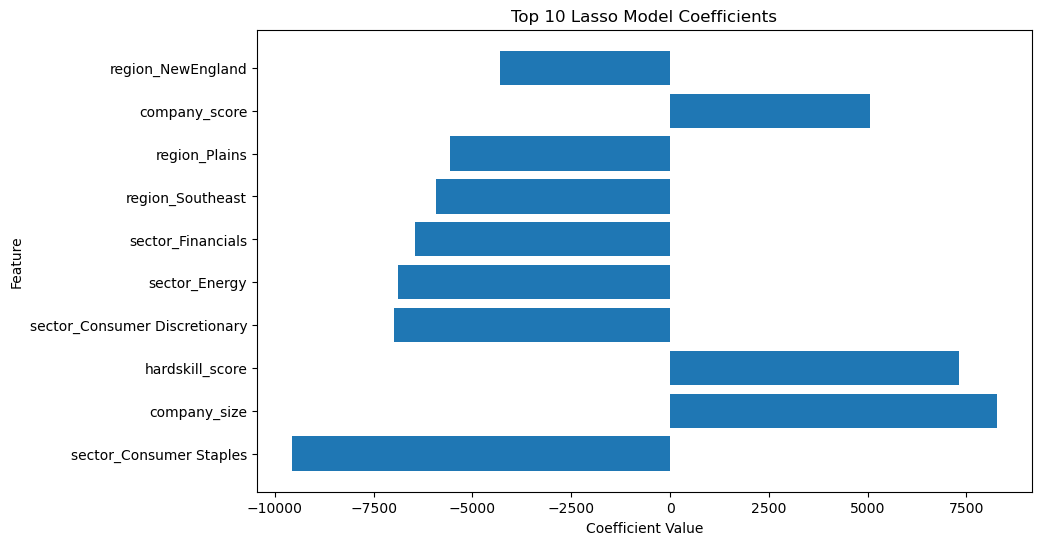

In [167]:
# Get the Lasso coefficients
coefficients = lasso_model.coef_

print(coefficients)
# Create a DataFrame for visualization
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Sort coefficients by magnitude for better visualization
top_10_coef = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)[:10]
print(top_10_coef)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_10_coef['Feature'], top_10_coef['Coefficient'])
plt.xlabel('Coefficient Value')


plt.ylabel('Feature')
plt.title('Top 10 Lasso Model Coefficients')
plt.show()

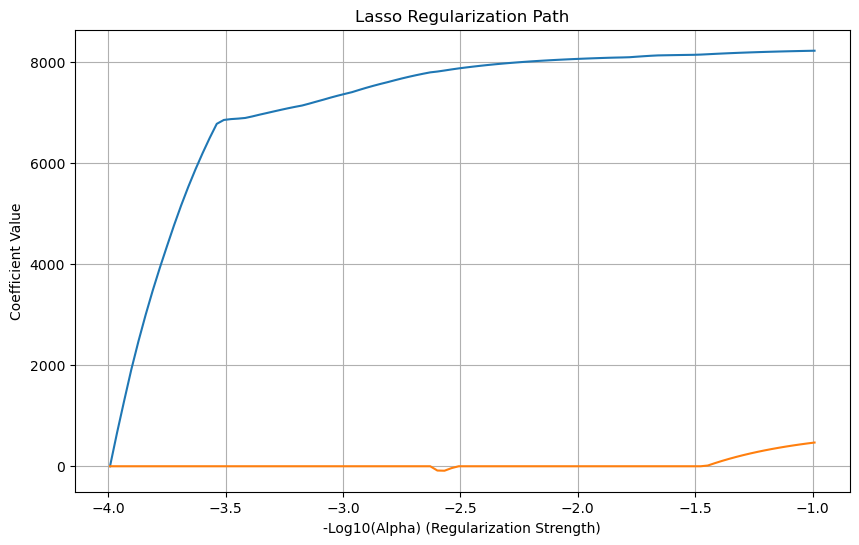

In [169]:
# Calculate the regularization path
alphas, coefs, _ = lasso_path(X_train, y_train)

# Plot the regularization path
plt.figure(figsize=(10, 6))

# Plot each coefficient's path
for i, feature in enumerate(top_10_coef):
    plt.plot(-np.log10(alphas), coefs[i], label=feature)

# Label the axes and title
plt.xlabel('-Log10(Alpha) (Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regularization Path')

plt.grid()
plt.show()

In [171]:
X.columns

Index(['company_size', 'moving_score', 'views', 'hardskill_score',
       'company_score', 'economic_score', 'sector_Consumer Discretionary',
       'sector_Consumer Staples', 'sector_Energy', 'sector_Financials',
       'sector_Health Care', 'sector_Industrials',
       'sector_Information Technology', 'sector_Materials',
       'sector_Real Estate', 'sector_Utilities', 'region_GreatLakes',
       'region_Mideast', 'region_NewEngland', 'region_Plains',
       'region_RockyMountain', 'region_Southeast', 'region_Southwest',
       'degree_level_bachelor, postgraduate', 'degree_level_postgraduate',
       'job_classification_Engineering', 'job_classification_Other'],
      dtype='object')

### -Model builidng with numeric predictors

In [173]:
#t_df2
#regression model using mostly numerical variables

dt_df2=df[['sector', 'region', 
          'degree_level','job_classification', 
          'company_size', 'moving_score','views','programming_languages_score',
        'analysis_statistics_score', 'machine_learning_score',
        'data_visualization_score', 'cloud_platform_score',
        'database_score', 'big_data_tools_score', 'big_data_score'
            ]]
dt_df2['company_score']=df['company_score']
dt_df2['economic_score']=df['economic_score']
dt_df2['over140k']=df['normalized_salary']>=140000
dt_df2['normalized_salary']=df['normalized_salary']




/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_63625/410831871.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_df2['company_score']=df['company_score']
/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_63625/410831871.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_df2['economic_score']=df['economic_score']
/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_63625/410831871.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [175]:
fill_na_with_mean(dt_df2,['moving_score','views','programming_languages_score',
                          'analysis_statistics_score', 'machine_learning_score',
                          'data_visualization_score', 'cloud_platform_score',
                          'database_score', 'big_data_tools_score', 'big_data_score',
                         'company_score','economic_score','company_size','views'] )

/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_63625/1226502658.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna(mean_value, inplace=True)


,sector,region,degree_level,job_classification,company_size,moving_score,views,programming_languages_score,analysis_statistics_score,machine_learning_score,data_visualization_score,cloud_platform_score,database_score,big_data_tools_score,big_data_score,company_score,economic_score,over140k,normalized_salary
0,Information Technology,Plains,bachelor,Engineering,2.000000,50.000000,7.0,1,0,1,1,1,0,0,0,-1.807878e+06,-1.283429e+06,False,75000.0
1,Energy,FarWest,bachelor,Engineering,2.000000,4.214518,6.0,1,0,1,1,1,1,0,0,-1.808273e+06,3.079390e+06,False,85000.0
2,Materials,FarWest,bachelor,Engineering,7.000000,4.703287,18.0,1,1,1,1,1,0,0,0,-1.720443e+06,-8.950336e+05,False,90927.5
3,Energy,Plains,bachelor,Other,5.251906,50.000000,59.0,1,1,1,1,1,1,0,0,-1.811867e+06,-1.283429e+06,False,63500.0
4,Materials,RockyMountain,bachelor,Engineering,5.000000,8.368978,6.0,1,1,1,2,0,0,0,0,-1.812367e+06,-1.213210e+06,False,82200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,Information Technology,GreatLakes,bachelor,Engineering,7.000000,17.304814,4.0,1,0,1,1,0,0,0,0,-8.529567e+05,-4.967535e+05,True,190050.0
3898,Information Technology,Southeast,bachelor,Engineering,7.000000,5.941396,4.0,3,2,1,1,1,0,0,0,-8.529567e+05,-8.587215e+05,False,112850.0
3899,Information Technology,FarWest,bachelor,Engineering,3.000000,4.214518,5.0,4,0,1,1,0,0,0,0,-1.809539e+06,3.079390e+06,True,159200.0
3900,Energy,FarWest,bachelor,Engineering,5.000000,4.214518,3.0,2,3,1,3,0,2,0,0,-1.730832e+06,3.079390e+06,False,137280.0


In [177]:
dt_df2.isnull().sum()

sector                         0
region                         0
degree_level                   0
job_classification             0
company_size                   0
moving_score                   0
views                          0
programming_languages_score    0
analysis_statistics_score      0
machine_learning_score         0
data_visualization_score       0
cloud_platform_score           0
database_score                 0
big_data_tools_score           0
big_data_score                 0
company_score                  0
economic_score                 0
over140k                       0
normalized_salary              0
dtype: int64

In [179]:

outliers_checkingn_cols = [ 'moving_score','views','programming_languages_score',
                          'analysis_statistics_score', 'machine_learning_score',
                          'data_visualization_score', 'cloud_platform_score',
                          'database_score', 'big_data_tools_score', 'big_data_score',
                         'company_score','economic_score']
remove_outliers_zscore_inplace(dt_df2,outliers_checkingn_cols, threshold=3)

/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_63625/2842136475.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[z_scores > threshold].index, inplace=True)


In [181]:
x2=dt_df2.drop(['normalized_salary','over140k'],axis=1)
y2=dt_df2['over140k']

In [183]:
x2 = pd.get_dummies(x2, drop_first=True)
# standardization
x_scaled2=preprocessing.scale(x2)

In [226]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(x_scaled2, y2, test_size=0.3, random_state=42)

tree_classifier = DecisionTreeClassifier(max_depth=2,          # Limit the depth of the tree
                                         min_samples_split=10, # Minimum samples needed to split a node
                                         random_state=42)  # You can adjust hyperparameters
tree_classifier.fit(X_train2, y_train2)

DecisionTreeClassifier(max_depth=2, min_samples_split=10, random_state=42)

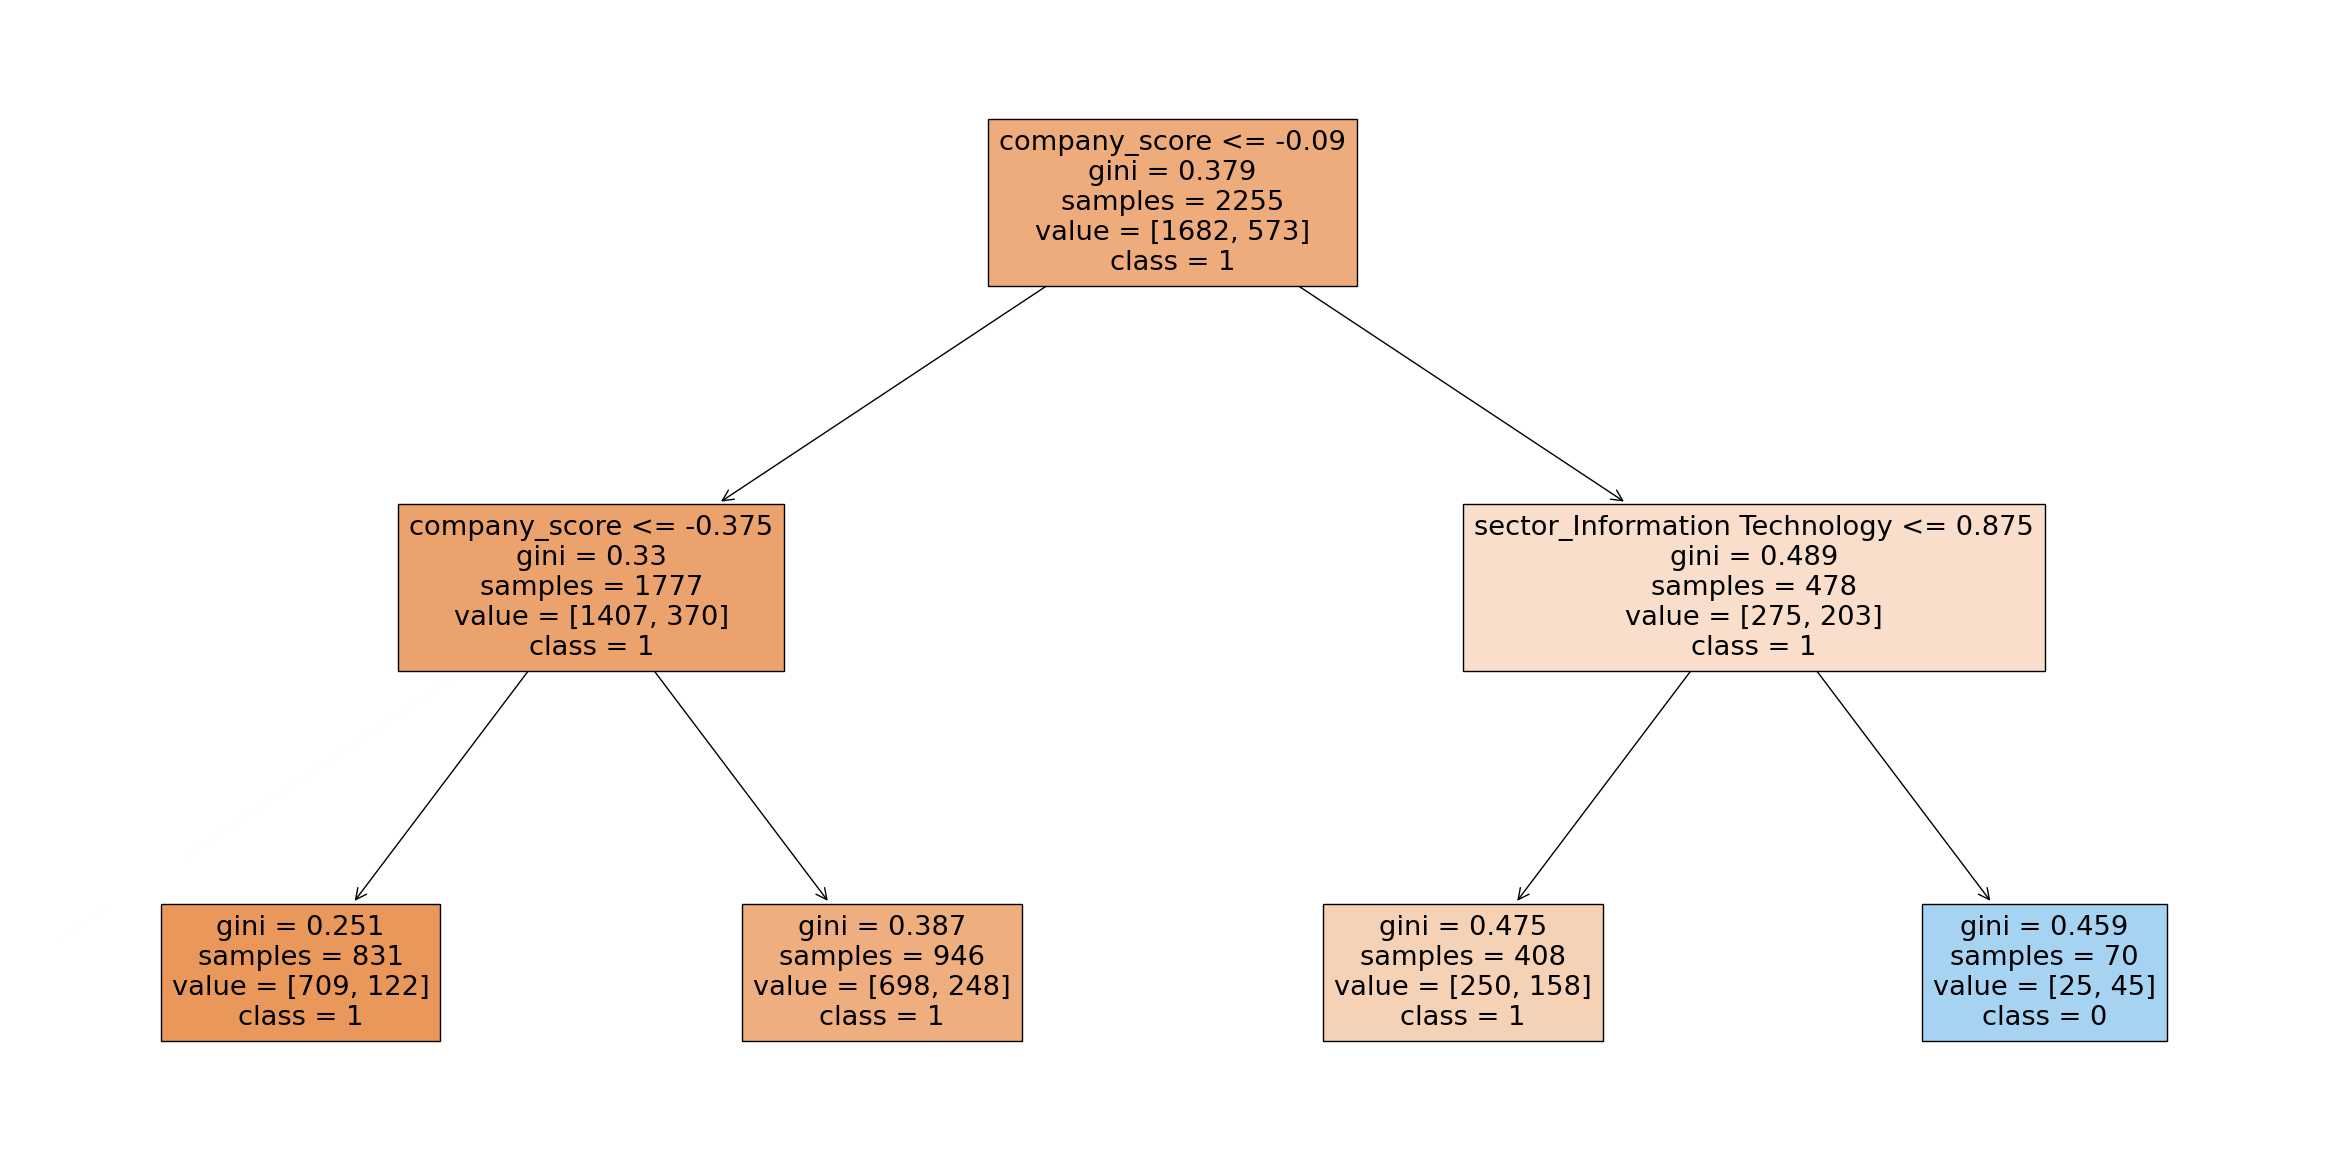

In [228]:
from sklearn.tree import plot_tree

plt.figure(figsize=(30, 15))
plot_tree(tree_classifier, feature_names=list(x2.columns), class_names=['1','0'], filled=True)
plt.show()

In [230]:
y_pred2 = tree_classifier.predict(X_test2)

In [232]:
print(classification_report(y_test2, y_pred2, target_names=['<=140k', '>140k']))

              precision    recall  f1-score   support

      <=140k       0.73      0.98      0.84       696
       >140k       0.57      0.07      0.13       271

    accuracy                           0.72       967
   macro avg       0.65      0.53      0.48       967
weighted avg       0.69      0.72      0.64       967



In [234]:
y_probs = tree_classifier.predict_proba(X_test2)

In [236]:
# For class '<=140k' (class 0)
fpr_class0, tpr_class0, thresholds_class0 = roc_curve(y_test2, y_probs[:, 0], pos_label=0)
roc_auc_class0 = auc(fpr_class0, tpr_class0)

# For class '>140k' (class 1)
fpr_class1, tpr_class1, thresholds_class1 = roc_curve(y_test2, y_probs[:, 1], pos_label=1)
roc_auc_class1 = auc(fpr_class1, tpr_class1)

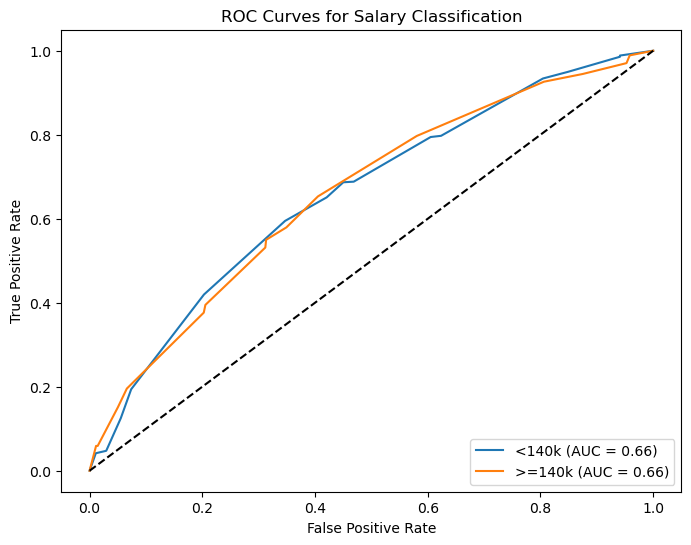

In [197]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_class0, tpr_class0, label=f'<140k (AUC = {roc_auc_class0:.2f})')
plt.plot(fpr_class1, tpr_class1, label=f'>=140k (AUC = {roc_auc_class1:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Salary Classification')
plt.legend(loc='lower right')
plt.show()

In [240]:
def get_top_predictors_in_branch(tree_classifier, X, node_id, branch_depth=3):
    """
    Gets the top predictors within a branch of a decision tree.

    Args:
        tree_classifier: The trained DecisionTreeClassifier object.
        X: The DataFrame containing the features.
        node_id: The ID of the starting node for the branch.
        branch_depth: The depth of the branch to analyze.

    Returns:
        A pandas Series containing the feature importance within the branch.
    """

    feature_indices = []
    current_depth = 0

    def traverse_branch(node_id, current_depth):
        if current_depth < branch_depth and node_id != -1:
            feature_indices.append(tree_classifier.tree_.feature[node_id])
            traverse_branch(tree_classifier.tree_.children_left[node_id], current_depth + 1)  # Left branch
            traverse_branch(tree_classifier.tree_.children_right[node_id], current_depth + 1)  # Right branch

    traverse_branch(node_id, current_depth)

    feature_names = X.columns[feature_indices]
    feature_importance_branch = pd.Series(feature_names).value_counts()

    return feature_importance_branch

# Analyze the first 3 branches (starting at the root node)
top_predictors_branch1 = get_top_predictors_in_branch(tree_classifier, x2, node_id=0)
print("Top Predictors in Branch 1:", top_predictors_branch1)

Top Predictors in Branch 1: job_classification_Engineering    4
company_score                     2
sector_Information Technology     1
Name: count, dtype: int64


In [294]:
# top predictors: company_score, IT_sectpr and being engieering 

## DT model with top predictors 

### - tree classifer 

In [242]:
x3=x2[['company_score','sector_Information Technology','programming_languages_score','machine_learning_score','economic_score']]

In [244]:
x_scaled3=preprocessing.scale(x3)

In [246]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(x_scaled3, y2, test_size=0.3, random_state=42)

tree_classifier = DecisionTreeClassifier(max_depth=3,          # Limit the depth of the tree
                                         min_samples_split=10, # Minimum samples needed to split a node
                                         random_state=42)  # You can adjust hyperparameters
tree_classifier.fit(X_train3, y_train3)

DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=42)

In [248]:
y_pred3 = tree_classifier.predict(X_test3)

In [250]:
print(classification_report(y_test3, y_pred3, target_names=['<=140k', '>140k']))

              precision    recall  f1-score   support

      <=140k       0.74      0.98      0.84       696
       >140k       0.62      0.10      0.17       271

    accuracy                           0.73       967
   macro avg       0.68      0.54      0.50       967
weighted avg       0.70      0.73      0.65       967



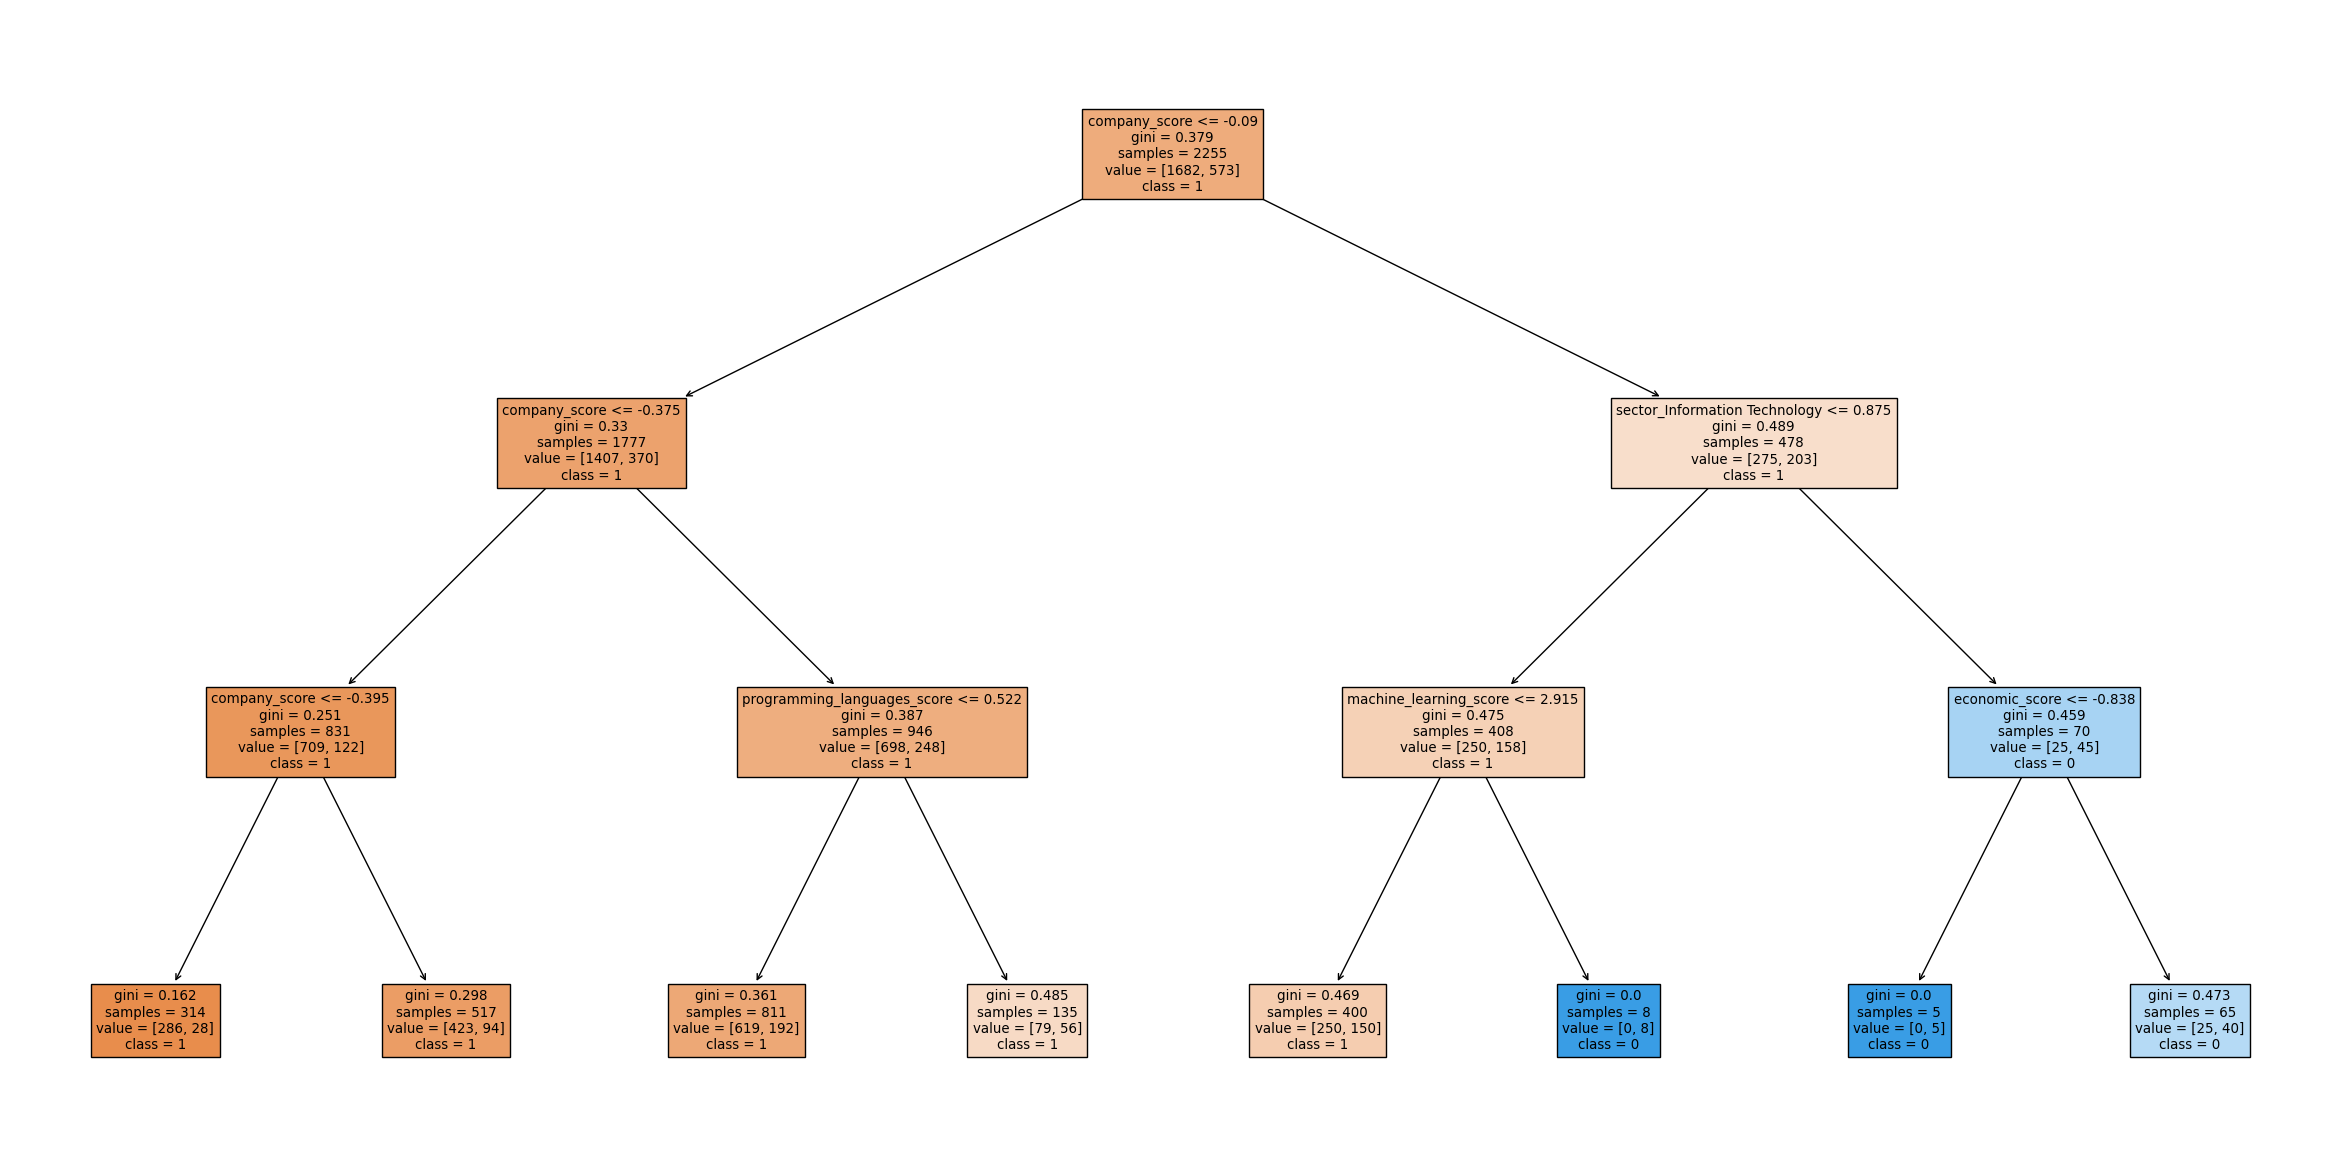

In [252]:
plt.figure(figsize=(30, 15))
plot_tree(tree_classifier, feature_names=list(x3.columns), class_names=['1','0'], filled=True)
plt.show()

### -Grid Search 

In [256]:
from sklearn.model_selection import GridSearchCV

# Define the Decision Tree model
dt_model3 = DecisionTreeRegressor(random_state=42)

# Hyperparameter grid to tune
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [1.0, 'sqrt', 'log2', None]
}

# Perform Grid Search for hyperparameter tuning
grid_search = GridSearchCV(estimator=dt_model3, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train3, y_train3)

# Get the best model from grid search
best_dt_model = grid_search.best_estimator_

# Evaluate the model
y_pred3 = best_dt_model.predict(X_test3)
r2_score = best_dt_model.score(X_test3, y_test3)
mae = mean_absolute_error(y_test3, y_pred3)
mse = mean_squared_error(y_test3, y_pred3)

print(f"Best Decision Tree Model Performance:")
print(f"R²: {r2_score:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

Best Decision Tree Model Performance:
R²: 0.0644
Mean Absolute Error: 0.3577
Mean Squared Error: 0.1887


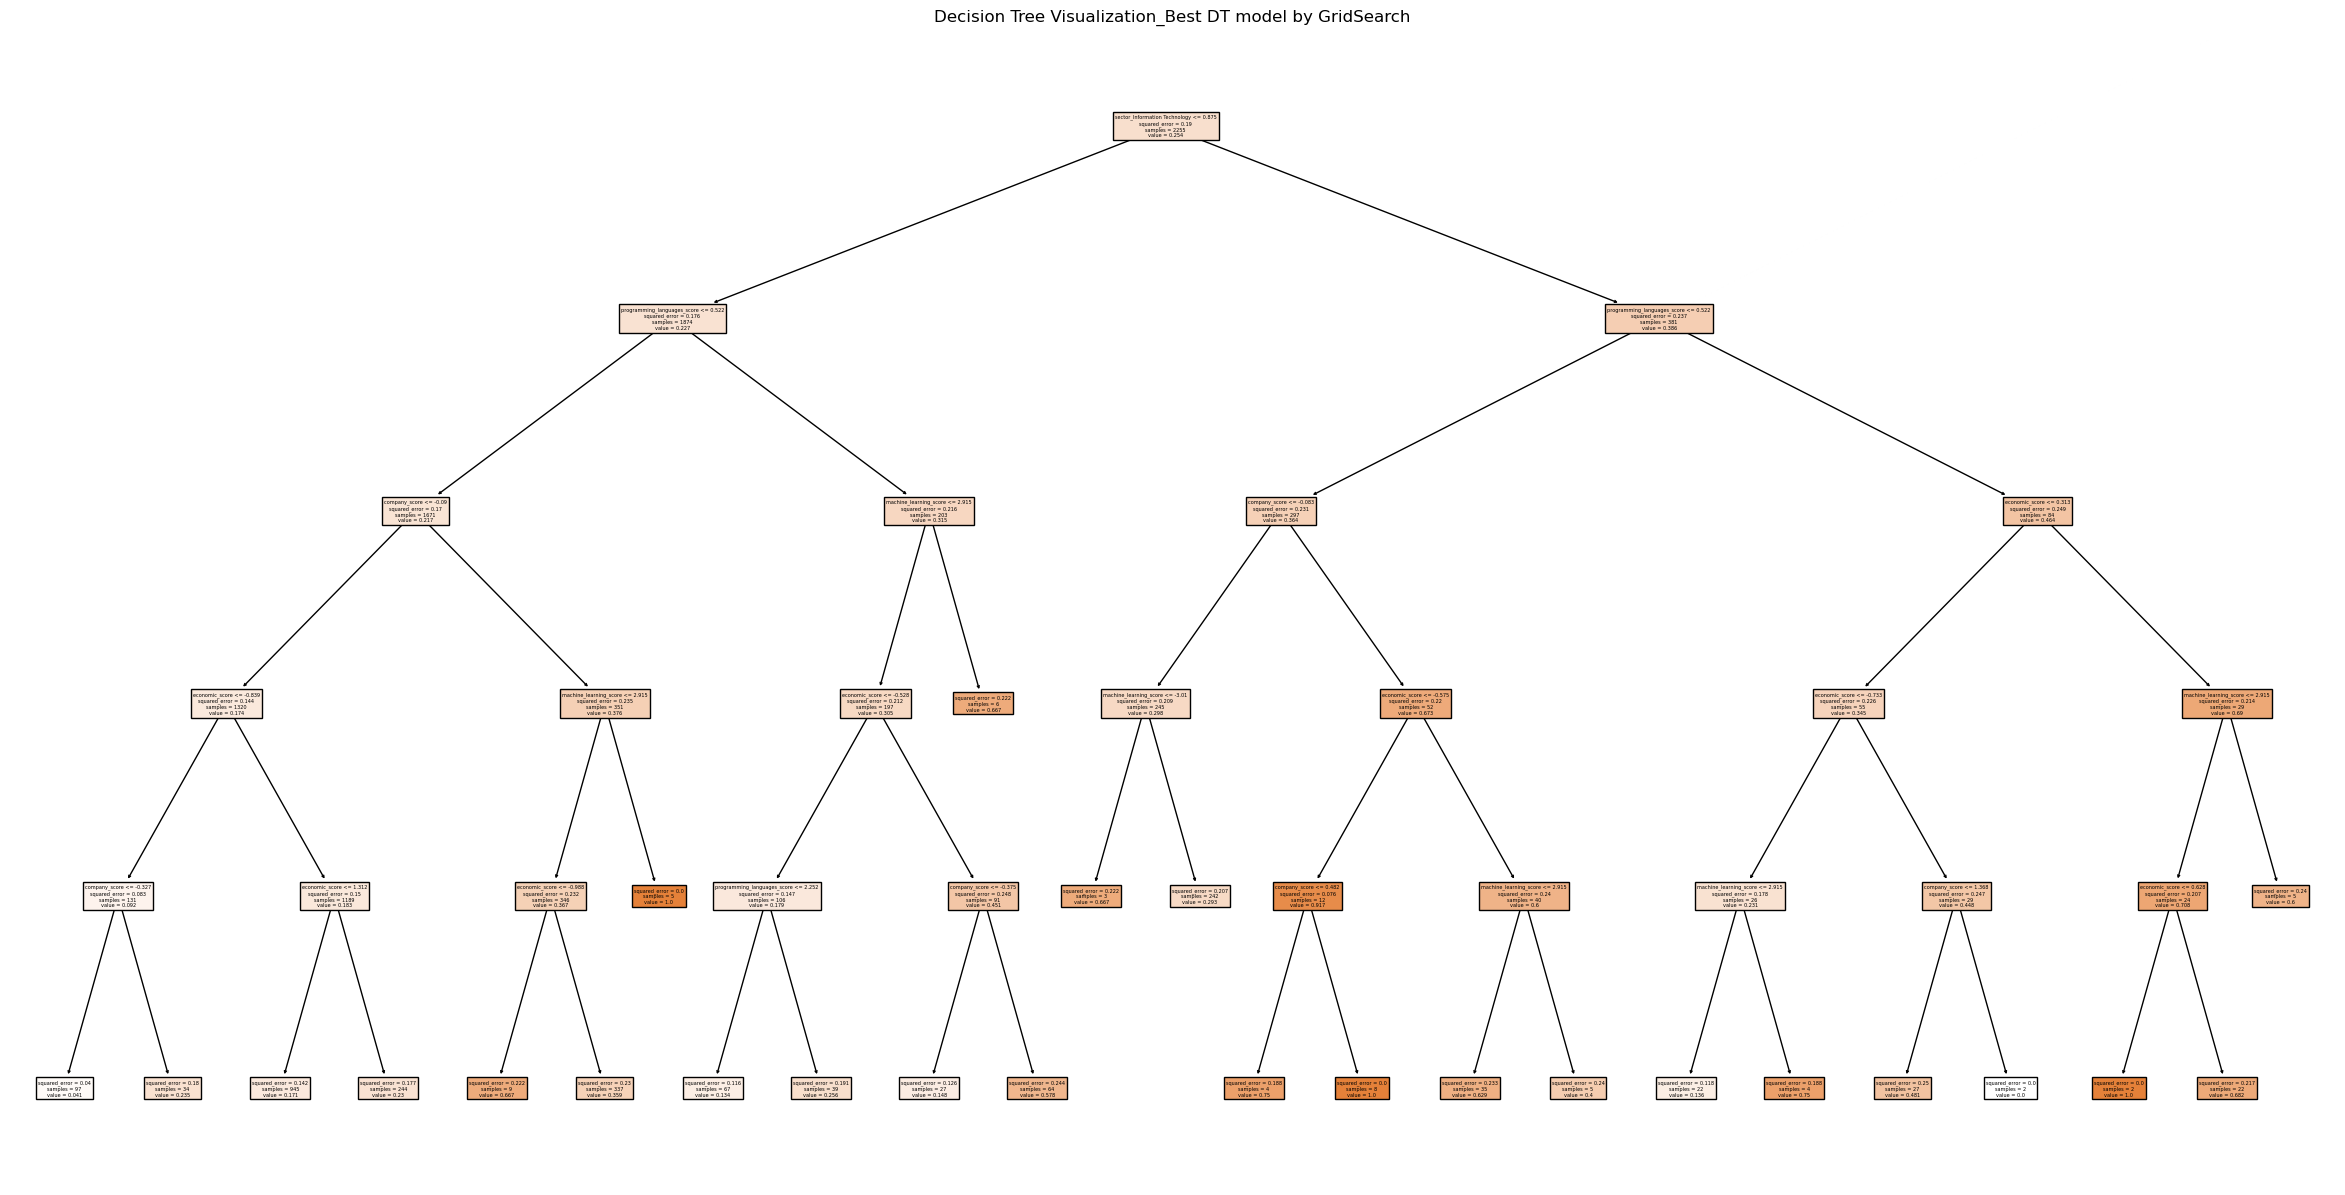

In [312]:
plt.figure(figsize=(30, 15))
plot_tree(best_dt_model, feature_names=list(x3.columns), class_names=['>=140k','<140k'], filled=True)
plt.title("Decision Tree Visualization_Best DT model by GridSearch")
plt.show()

### - Randam Forest model 

In [218]:
from sklearn.ensemble import RandomForestRegressor

# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [1.0, 'sqrt', 'log2']
}

# Perform GridSearchCV to tune hyperparameters
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train3, y_train3)

# Get the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_

# Make predictions with the best model
y_pred_rf = best_rf_model.predict(X_test3)

# Evaluate the Random Forest model
r2_rf = best_rf_model.score(X_test3, y_test3)
mae_rf = mean_absolute_error(y_test3, y_pred_rf)
mse_rf = mean_squared_error(y_test3, y_pred_rf)

print(f"Random Forest Model Performance:")
print(f"R²: {r2_rf:.4f}")
print(f"Mean Absolute Error: {mae_rf:.4f}")
print(f"Mean Squared Error: {mse_rf:.4f}")

Random Forest Model Performance:
R²: 0.1097
Mean Absolute Error: 0.3452
Mean Squared Error: 0.1796


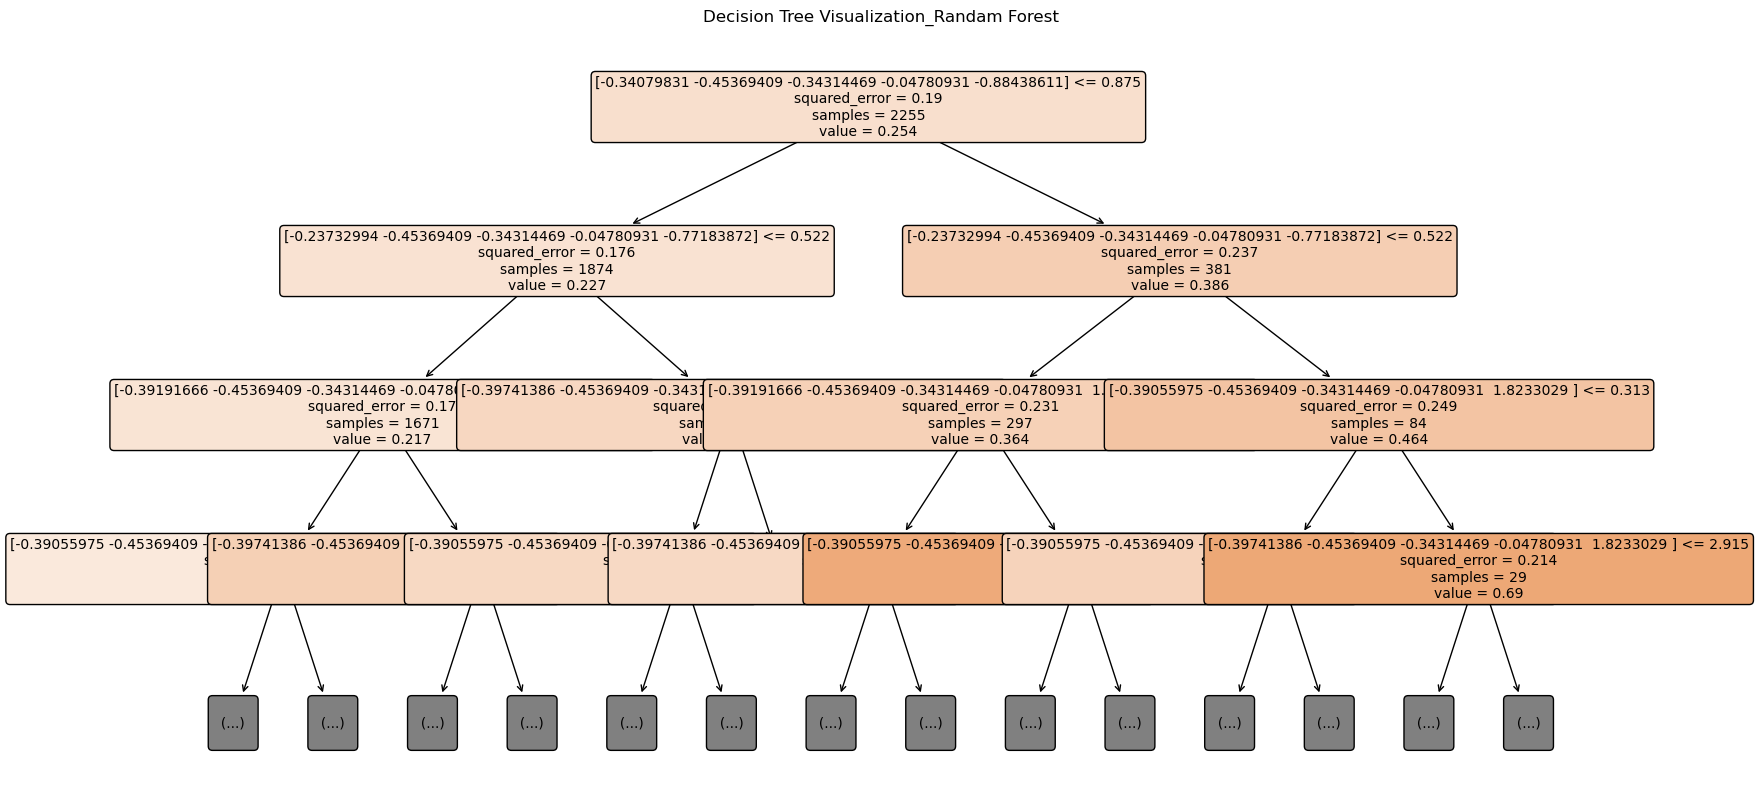

In [310]:

# Plot the decision tree
plt.figure(figsize=(18, 10))  

plot_tree(
    best_dt_model, max_depth= 3,
    feature_names=list(X_train3),  # Provide feature names for the splits
    class_names=['Class 0', 'Class 1'], 
    filled=True,  # Color the nodes by purity
    rounded=True,  # Use rounded boxes for nodes
    fontsize=10  # Adjust font size for readability
)
plt.title("Decision Tree Visualization_Randam Forest")
plt.show()

### - xgboost model

In [65]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
import numpy as np


# Initialize XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

# Train the model
xg_reg.fit(X_train2, y_train2)

# Predictions on test set
y_pred3 = xg_reg.predict(X_test2)

# Evaluate the model performance
r2 = r2_score(y_test2, y_pred3)
mae = mean_absolute_error(y_test2, y_pred3)
mse = mean_squared_error(y_test2, y_pred3)

# Print performance metrics
print(f"XGBoost Model Performance:")
print(f"R²: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Perform K-fold cross-validation to check model's stability
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xg_reg, x_scaled2, y2, cv=kf, scoring='r2')

# Print K-Fold cross-validation results
print(f"K-Fold Cross-Validation (R²):")
print(f"Mean R²: {np.mean(cv_scores):.4f}, Std: {np.std(cv_scores):.4f}")

XGBoost Model Performance:
R²: 0.0335
Mean Absolute Error (MAE): 0.3830
Mean Squared Error (MSE): 0.1950
K-Fold Cross-Validation (R²):
Mean R²: 0.0390, Std: 0.0040
